In [1]:
# -*- coding:utf-8 -*-
# Author : Younger Huang
# Date : 2023.11.04

import torch
import numpy as np
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32 * 32)
        self.br1 = nn.Sequential(
            nn.BatchNorm1d(32 * 32),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(32 * 32, 128 * 7 * 7)
        self.br2 = nn.Sequential(
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU()
        )
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 4, stride = 2, padding = 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.br1(self.fc1(x))
        x = self.br2(self.fc2(x))
        x = x.reshape(-1, 128, 7, 7)
        x = self.conv1(x)
        x = self.conv2(x)
        return x
        

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride = 1),
            nn.LeakyReLU(0.2)
        )
        self.pl1 = nn.MaxPool2d(2, stride = 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, stride = 1),
            nn.LeakyReLU(0.2)
        )
        self.pl2 = nn.MaxPool2d(2, stride = 2)
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1024),
            nn.LeakyReLU(0.2)
        ) 
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pl1(x)
        x = self.conv2(x)
        x = self.pl2(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    

def train():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    batch_size = 64
    
    train_dataset = datasets.MNIST(
        root = './data/',
        train = True,
        transform = transforms.ToTensor(),
        download = True
    )
    train_loader = DataLoader(
        dataset = train_dataset,
        batch_size = batch_size,
        shuffle = True
    )
    
    input_dim = 100
    num_epoch = 20
    G = Generator(input_dim).to(device)
    D = Discriminator().to(device)
    optim_G = torch.optim.Adam(G.parameters(), lr = 0.0002)
    optim_D = torch.optim.Adam(D.parameters(), lr = 0.0002)
    loss_func = nn.BCELoss()
    
    for epoch in range(num_epoch):
        total_loss_D, total_loss_G = 0, 0
        for i, (x, _) in enumerate(train_loader):
            real_x = x.to(device)
            real_output = D(real_x)
            real_loss = loss_func(real_output, torch.ones_like(real_output).to(device))
            #real_loss = torch.mean((real_output - 1.) ** 2)
            fake_x = G(torch.randn([batch_size, input_dim]).to(device)).detach()
            fake_output = D(fake_x)
            fake_loss = loss_func(fake_output, torch.zeros_like(fake_output).to(device))
            #fake_loss = torch.mean(fake_output ** 2)
            loss_D = real_loss + fake_loss
            
            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()
            
            fake_x = G(torch.randn([batch_size, input_dim]).to(device))
            fake_output = D(fake_x)
            loss_G = loss_func(fake_output, torch.ones_like(fake_output).to(device))
            #loss_G = 0.5 * torch.mean((fake_output - 1.) ** 2)
            
            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()
            
            total_loss_D += loss_D
            total_loss_G += loss_G
            
            if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
                print('Epoch {:02d} | Step {:04d} / {} | Loss_D {:.4f} | Loss_G {:.4f}'.format(epoch, i + 1, len(train_loader), total_loss_D / (i + 1), total_loss_G / (i + 1)))
                
        x = torch.randn(64, input_dim).to(device)
        img = G(x)
        save_image(img, './res2/' + '%d_epoch.png'%(epoch))
    
if __name__ == '__main__':
    train()
        

Epoch 00 | Step 0100 / 938 | Loss_D 0.0577 | Loss_G 0.4785
Epoch 00 | Step 0200 / 938 | Loss_D 0.0363 | Loss_G 0.4871
Epoch 00 | Step 0300 / 938 | Loss_D 0.0539 | Loss_G 0.4687
Epoch 00 | Step 0400 / 938 | Loss_D 0.0797 | Loss_G 0.4456
Epoch 00 | Step 0500 / 938 | Loss_D 0.1001 | Loss_G 0.4283
Epoch 00 | Step 0600 / 938 | Loss_D 0.1171 | Loss_G 0.4138
Epoch 00 | Step 0700 / 938 | Loss_D 0.1349 | Loss_G 0.3981
Epoch 00 | Step 0800 / 938 | Loss_D 0.1489 | Loss_G 0.3849
Epoch 00 | Step 0900 / 938 | Loss_D 0.1607 | Loss_G 0.3748
Epoch 00 | Step 0938 / 938 | Loss_D 0.1647 | Loss_G 0.3713
Epoch 01 | Step 0100 / 938 | Loss_D 0.2615 | Loss_G 0.2862
Epoch 01 | Step 0200 / 938 | Loss_D 0.2674 | Loss_G 0.2834
Epoch 01 | Step 0300 / 938 | Loss_D 0.2716 | Loss_G 0.2809
Epoch 01 | Step 0400 / 938 | Loss_D 0.2735 | Loss_G 0.2805
Epoch 01 | Step 0500 / 938 | Loss_D 0.2749 | Loss_G 0.2793
Epoch 01 | Step 0600 / 938 | Loss_D 0.2763 | Loss_G 0.2785
Epoch 01 | Step 0700 / 938 | Loss_D 0.2782 | Loss_G 0.27

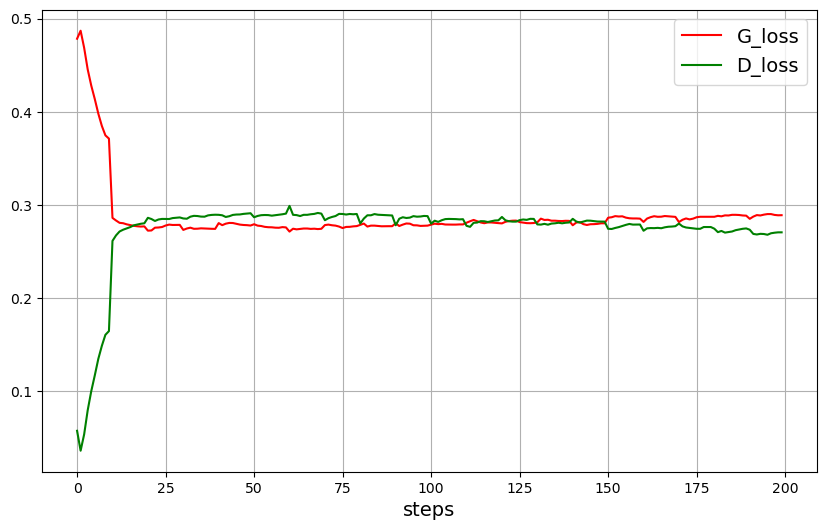

In [19]:
import numpy as np
import matplotlib.pyplot as plt

g_loss, d_loss = [], []
with open('./loss.log', 'r') as f:
    for line in f.readlines():
        tmp = line.rstrip().split()
        g_loss.append(float(tmp[-1]))
        d_loss.append(float(tmp[-4]))
plt.figure(figsize = (10, 6))
plt.plot(g_loss, color = 'r', label = 'G_loss')
plt.plot(d_loss, color = 'green', label = 'D_loss')
plt.legend(fontsize = 14)
plt.xlabel('steps', fontsize = 14)
plt.grid(True)
plt.savefig('loss.png', dpi = 400)
plt.show()